In [1]:
from ctypes import *
import numpy as np
from ctypes import cdll
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from IPython.display import clear_output
import os
import numpy as np
from PIL import Image


In [2]:
def import_images_and_assign_labels(
        folder, label, X, Y
):
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        im = Image.open(image_path)
        im = im.resize((32, 32))
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (32 * 32 * 3))
        X.append(im_arr)
        Y.append(label)

def import_dataset():

    dataset_folder = "C:/Users/bowet/Documents/projet_cdll/dataSet/"
    train_folder = os.path.join(dataset_folder, "train")
    test_folder = os.path.join(dataset_folder, "test")

    X_train = []
    y_train = []
    import_images_and_assign_labels(
        os.path.join(train_folder, "planete"),[-1.0, 1.0], X_train, y_train
    )
    import_images_and_assign_labels(
        os.path.join(train_folder, "pasplanete"), [-1.0, -1.0], X_train, y_train
    )
    X_test = []
    y_test = []
    import_images_and_assign_labels(
        os.path.join(test_folder, "planete"),[-1.0, 1.0], X_test, y_test
    )
    import_images_and_assign_labels(
        os.path.join(test_folder, "pasplanete"),[-1.0, -1.0], X_test, y_test
    )
    return (np.array(X_train) / 255.0, np.array(y_train)), \
           (np.array(X_test) / 255.0, np.array(y_test))


In [3]:
class MLPWrapper() :

    def __init__(self, npl: [int], is_classification: bool = True,
               alpha: float = 0.01, iterations_count: int = 1000):

        path_to_dll = "C:/Users/bowet/Documents/projet_cdll/cmake-build-debug/projet_cdll.dll"
        mylib = cdll.LoadLibrary(path_to_dll)

        init_size = len(npl)
        init_type = c_int * init_size
        init = init_type(*npl)
        mylib.create_mlp_model.argtypes = [init_type, c_int]
        mylib.create_mlp_model.restype = c_void_p

        self.model = mylib.create_mlp_model(init, int(init_size))
        self.is_classification = is_classification
        self.alpha = alpha
        self.iterations_count = iterations_count
        print("wrapper initialisé")


    def fit(self, X, Y):
        path_to_dll = "C:/Users/bowet/Documents/projet_cdll/cmake-build-debug/projet_cdll.dll"
        mylib = cdll.LoadLibrary(path_to_dll)


        if self.is_classification:
            dataset_inputs = np.array(X)
            dataset_expected_outputs = np.array(Y)

            flattened_dataset_inputs = dataset_inputs.flatten()



            # definition de train_classification_stochastic_gradient....
            arrsize_flat = len(flattened_dataset_inputs)
            arrtype_flat = c_float * arrsize_flat
            arr_flat = arrtype_flat(*flattened_dataset_inputs)

            arrsize_exp = len(dataset_expected_outputs.flatten())
            arrtype_exp = c_float * arrsize_exp
            arr_exp = arrtype_exp(*dataset_expected_outputs.flatten())


            mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.argtypes = [c_void_p, arrtype_flat,
                                                                                                 c_int,
                                                                                                 arrtype_exp, c_float,
                                                                                                 c_int]
            mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.restype = None

            mylib.train_classification_stochastic_gradient_backpropagation_mlp_model(self.model, arr_flat, arrsize_flat, arr_exp,
                                                                                     self.alpha, self.iterations_count)

        else:
            mylib.train_regression_stochastic_gradient_backpropagation_mlp_model(self.model,
                                                                         X.flatten(),
                                                                         Y.flatten(),
                                                                         self.alpha,
                                                                         self.iterations_count)

    def predict(self, X):
        path_to_dll = "C:/Users/bowet/Documents/projet_cdll/cmake-build-debug/projet_cdll.dll"
        mylib = cdll.LoadLibrary(path_to_dll)

        mylib.getLengthX.argtypes = [c_void_p]
        mylib.restype = c_int
        tmp_len = mylib.getLengthX(self.model)

        if not hasattr(X, 'shape'):
          X = np.array(X)

        if len(X.shape) == 1:
          X = np.expand_dims(X, axis=0)


        predicted_outputs = []
        for p in X:
            if self.is_classification:
                arrsizeP = len(p)
                arrtypeP = c_float * arrsizeP
                arrP = arrtypeP(*p)
                mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
                mylib.predict_mlp_model_classification.restype = POINTER(c_float)
                tmp = mylib.predict_mlp_model_classification(self.model, arrP)
                np_arr = np.ctypeslib.as_array(tmp, (tmp_len,))
                l = []
                for i in np_arr:
                    l.append(i)
                predicted_outputs.append(l)


        return predicted_outputs

In [4]:
(X_train, y_train), (X_test, y_test) = import_dataset()

epoch = 22 , loss = 0.04571795885902411, val_loss = 1.3230793371832305e-05, acc = 0.5864440078585462, val_acc = 0.6
Fin de l'entrainement


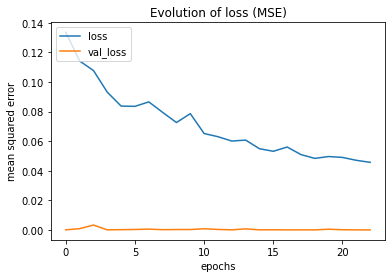

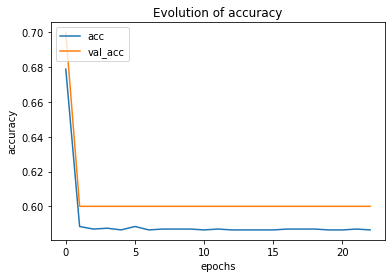

KeyboardInterrupt: 

In [16]:


path_to_dll = "C:/Users/bowet/Documents/projet_cdll/cmake-build-debug/projet_cdll.dll"
mylib = cdll.LoadLibrary(path_to_dll)

dataset_inputs = np.array(X_train)
dataset_expected_outputs = np.array(y_train)

init_tab = [len(X_train[0]),16, 2]

print("initialisation du wrapper")
wrapped_model = MLPWrapper(init_tab, iterations_count =len(X_train))

losses = []
val_losses = []

accs = []
val_accs = []

# print(len(y_train))
# # print(y_test)
print("début de l'entrainement")
for epoch in range(50):
    wrapped_model.fit(X_train, y_train)

    y_pred = wrapped_model.predict(X_train)
    
    loss = mean_squared_error(y_train, y_pred)
    losses.append(loss)
    
    val_y_pred = wrapped_model.predict(X_test)
    val_loss = mean_squared_error(y_test, val_y_pred)
    val_losses.append(val_loss)

    
    # print("y_train : ",y_train)
    # print("acc_pred : ",acc_pred)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_pred, axis=1))
    
    accs.append(acc)


    
    # print("y_test : ",y_test)
    # print("acc_val : ",acc_val_y)

    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(val_y_pred, axis=1))
    val_accs.append(val_acc)
    clear_output()
    print(f"epoch = {epoch} , loss = {loss}, val_loss = {val_loss}, acc = {acc}, val_acc = {val_acc}")

    print("Fin de l'entrainement")
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.title('Evolution of loss (MSE)')
    plt.xlabel('epochs')
    plt.ylabel(f'mean squared error')
    plt.show()

    plt.plot(accs)
    plt.plot(val_accs)
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.title('Evolution of accuracy')
    plt.xlabel('epochs')
    plt.ylabel(f'accuracy')
    plt.show()









In [ ]:
Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
from sklearn.metrics import confusion_matrix
y_pred = wrapped_model.predict(X_train)
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(wrapped_model.predict(X_test), axis=1))

array([[0, 4],
       [0, 6]], dtype=int64)